#### First Pass of Paper

Abstract:
Larger networks have large capacity, but they also have a propensity to overfit. A known method (maybe like XG boost or tree ensambles) that can help overfitting is to create many networks and then combine their predictions. This is expensive computationally for large networks. Dropout addresses this problem, the core idea is to randomly drop units and their connections during training. This prevents units from co-adapting too much. Dropout creates many different thinned networks. At test time you average the prediction by simply using the single network with smaller weights. This reduces overfitting and gives improvements over other methods.


Introduction:
Goes over the problem of overfitting, a powerful model will learn relationships that are just "sampling noise", random quirks about the specific data presented, not the true properties of the underlying data distribution. It then goes over a few of the classic methods to prevent overfitting:
1. Stop training as soon as performance on validation set gets worse
2. L1 / L2 regularization
3. Soft weight sharing?

If you have unlimited compute, the best way to regularize a fixed-sized model is to "average the predictions of all possible settings of the parameters, weighting each setting by its posterior probability given the training data"

This means we find every possible combination of values for the weights (massive space lol). Then, (in theory) we look at every single one of those combinations and weight it by their posterior probability, a measure of how "good" it is as a setting. The way we calculate this weighting is by looking for each of those combos, how likely this configuration is after seeing all the data. A combo that fits the data well will have higher posterior probability.

So in essence, the best model or the "Bayesian gold standard" is the weighted average of all possible models weighted by how well they did on the data.

This obviously isn't feasable, but we can approach that by using dropout. Dropout trains and averages probably a pretty good combination of pretty good combos of models. It averages all of these models that all share weights, all within one network.

Dropout temporarily removes certain units from the network. Each unit is retained with a fixed probability p, a good number for p for units is 0.5. The exception is for input units, which we want to set p closer to 1 (makes sense to me as we don't want to just miss out on input data coming in).

A network with n units can be seen as a collection of 2^n possible thinned networks. They share weights though, total number of parameters remains the same. For each new training case a new network is sampled and trained. This means that each thinned networks gets trained maybe once or very few times.

Question: What happens if you apply this thinning to make k thinned networks? That is to say you apply the dropout probability k times in a row? So that each of those thinned networks would get a few more datapoints / cycles.

At the end you don't need to explicitly average the predictions from the networks. You just scale down the trained weights.

**If a unit is retained with probability p during training, the outgoing weights of that unit are multiplied by p at test time**

Motivation:

This is cool. The idea comes from the role of sex in evolution. This is kinda related to what I was reading in The Selfish Gene. Half the genes come from one parent and the other from the other. Each gene is kind of small. Asexual alternative is to just create it based on itself with some mutations. Sexual reproduction is "good" because it breaks up co-adapted gene sets, and also forces selection for genes that can work well with each other and by itself. Each hidden unit in a neural network must learn to work with a randomly chosen sample of other units.

Model Description:

Essentially what we do is that for any given layer we construct a vector r of random variables drawn from a Bernoulli distribution with probability p the same shape as the input vector. That means that it will be a vector of 1's and 0s where the proability that a given element is 1 is p and the probability an element is 0 is 1-p.

When we take in the y from a previous layer (or input) we first do an element wise multiply with our r vector. Then we continue as normal.

For modern implementations inverted dropout is used instead of using the trick of scaling it back up. After applying the mask, we scale up the activations by multiplying all of them (after we element multiply by r) by 1/p. Then we can just use the network as is during test time.

Learning Dropout Nets:

Training uses SGD. For each training example a random mask is generated and the forward pass is done on the thinned networks and the backwards pass is done only along the paths of the surviving neurons. You won't really have to do anything for this I don't think as the gradients for those dropped connections will be 0 since they get multiplied by 0.

One technique they found that was helpful with dropout is to constrain the L2 norm of the incoming vector for each neuron. You set it to be maximum ||weight|| <= c where c is some hyper parameter.

Note: I don't see why this couldn't be used with Adam as well.

Salient Features:
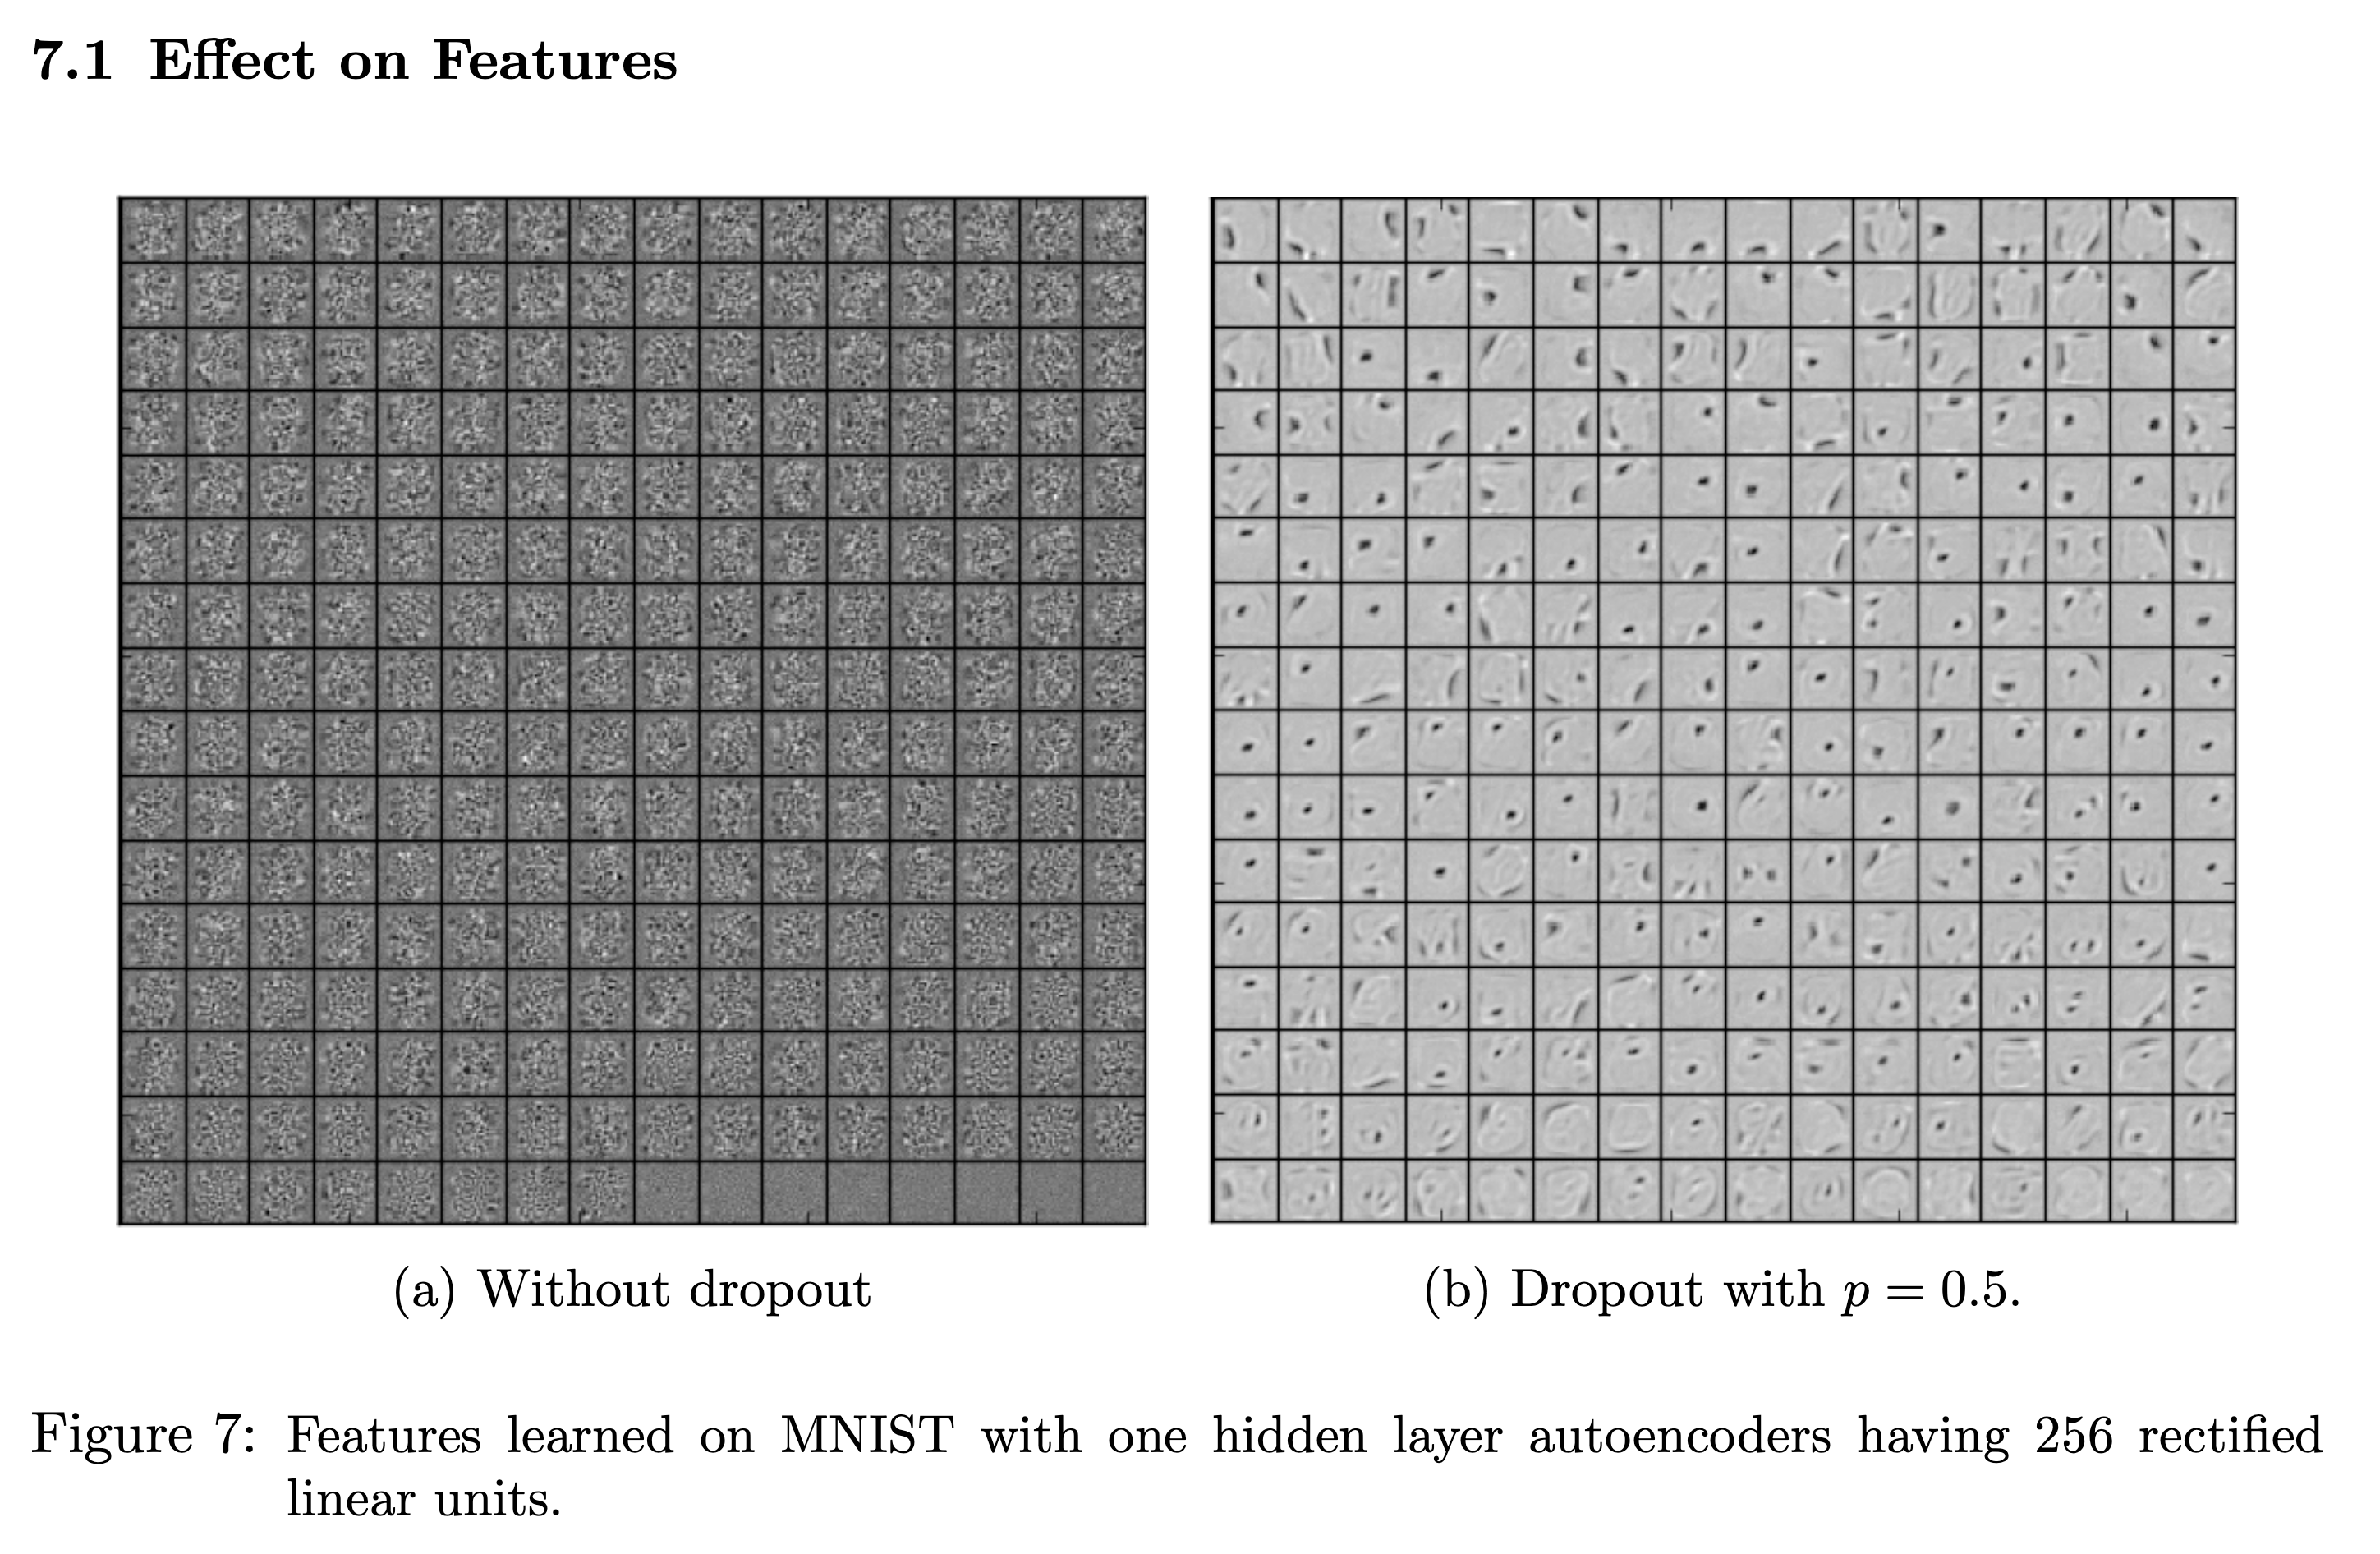

This diagram in the paper is quite interesting. It shows how with dropout it visually looks like it's learning much cleaner features.

Each neuron must perform well in a wide variety of different contexts provided by the other units.

Dropout has another side-effect of making activations sparse, this, as we've seen from other papers is a desireable good thing.

It seems that if there is too much dropout then the network can't fit it well. If it's too high (not enough dropout or base case) then the network will overfit. There's a sweet spot somewhere around 0.4 - 0.8.

In [60]:
### Try to add in dropout to my code here

# compare tanh, relu, sigmoid and softplus on same training I had from lenet with MLP
from tensorflow.keras.datasets import mnist
import torch

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)

x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)
print(len(x_train), len(x_test))

import random
import math

class Fully_Connected_Layer():
    def __init__(self, nin, nout, activation_function, dropout_p):
        self.w = torch.randn(nin, nout)
        self.w.mul_(math.sqrt(2.0 / nin)) 
        self.w.requires_grad_()                 
        self.b = torch.randn(nout, requires_grad=True)
        self.activation_function = activation_function
        self.dropout_p = dropout_p

    def __call__(self, x, training=True):
        # we apply dropout to the input before anything else and then scale it
        if(training):
            mask = torch.bernoulli(torch.full((x.shape), self.dropout_p, dtype=torch.float32))
            x = x * mask
            if(self.dropout_p != 0):
                x = x / self.dropout_p
        act = (x @ self.w) + self.b
        return torch.relu(act)

    def parameters(self):
        return [self.w, self.b]

class MLP():
    def __init__(self, nin, nouts, activation_function, dropout_input_p, dropout_p):
        sz = [nin] + nouts
        self.layers = []
        for i in range(len(nouts)- 1):
            if i == 0:
                self.layers.append(Fully_Connected_Layer(sz[i], sz[i+1], activation_function, dropout_input_p))
            else:
                self.layers.append(Fully_Connected_Layer(sz[i], sz[i+1], activation_function, dropout_p))
        self.layers.append(Fully_Connected_Layer(sz[-2], sz[-1], "none", 1))
        self.activation_function = activation_function

    def __call__(self, x, training=True):
        for layer in self.layers:
            x = layer(x, training)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

def loss_individual(model_outputs, target_label_index):
    max_logit = torch.max(model_outputs)
    shifted_logits = model_outputs - max_logit
    exp = torch.exp(shifted_logits)
    sum_exp = torch.sum(exp)
    target_exp = exp[target_label_index]
    softmax_target = target_exp / sum_exp

    # negative log liklihood
    eps = 1e-12
    loss = -torch.log(softmax_target + eps)
    return loss

60000 10000


In [61]:
class Adam_Optimizer():
    def __init__(self, parameters, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.parameters = parameters
        self.lr = learning_rate
        self.b1 = beta1
        self.b2 = beta2
        self.eps = epsilon
        self.t = 0
        self.m = [torch.zeros_like(p) for p in self.parameters]
        self.v = [torch.zeros_like(p) for p in self.parameters]

    def step(self):
        self.t += 1
        with torch.no_grad():
            for i, p in enumerate(self.parameters):
                self.m[i] = self.b1 * self.m[i] + (1 - self.b1) * p.grad
                self.v[i] = self.b2 * self.v[i] + (1 - self.b2) * (p.grad**2)
                
                m_hat = self.m[i] / (1 - self.b1**self.t)
                v_hat = self.v[i] / (1 - self.b2**self.t)
                
                p -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

    def zero_grad(self):
        for p in self.parameters:
            p.grad.zero_()



--- Training with dropout: (1, 1) ---
epoch done...
epoch done...
epoch done...
epoch done...
epoch done...
FINAL validation loss: 1.9005
Finished (1, 1) in 1777.22s

--- Training with dropout: (0.85, 0.6) ---
epoch done...
epoch done...
epoch done...
epoch done...
epoch done...
FINAL validation loss: 2.3026
Finished (0.85, 0.6) in 4403.10s


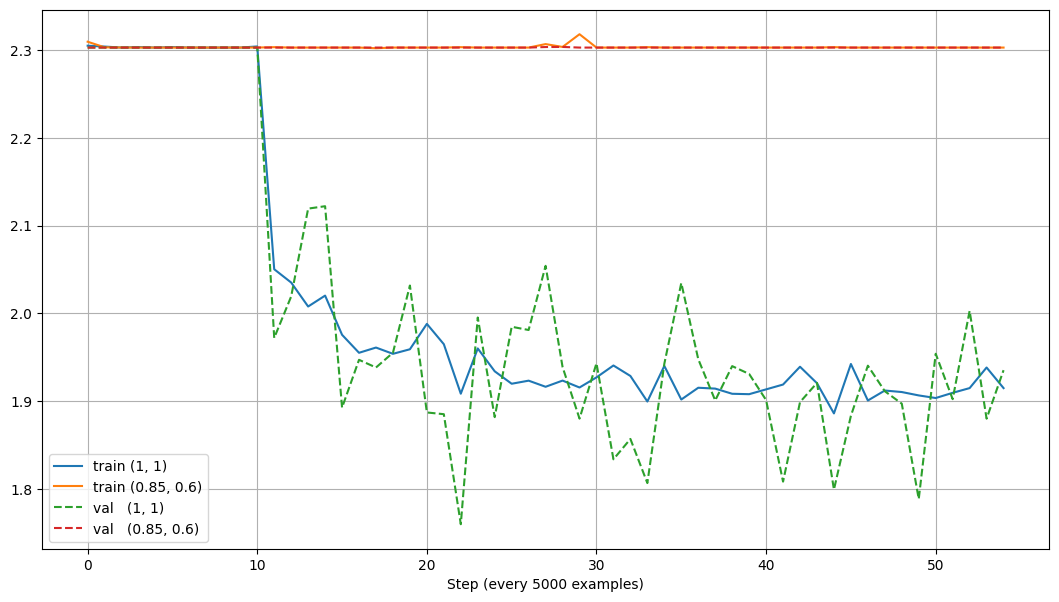

In [67]:
import time
import matplotlib.pyplot as plt

dropout_values = [(1,1), (0.85, 0.6)]

losses_by_dropout_values = {}
val_losses_by_dropout_values = {}

# number of samples for validation loss estimate throughout training
k = 250

for dropout_tuple in dropout_values:
    print(f"\n--- Training with dropout: {dropout_tuple} ---")
    start_time = time.time()
    
    lossi, val_lossi = [], []
    mnist_mlp = MLP(28*28, [512, 512, 10], "relu", dropout_tuple[0], dropout_tuple[1])
    optimizer = Adam_Optimizer(mnist_mlp.parameters(), learning_rate=0.002)

    lambda_val = 0.0001
    print_reset_error_interval = 5000
    cumulative_error = 0
    epochs = 5
    examples_per_epoch = 60000

    for epoch in range(epochs):
        for i in range(examples_per_epoch):
            out = mnist_mlp(torch.flatten(x_train[i]))
            weights_sum = sum((p**2).sum() for p in mnist_mlp.parameters() if p.dim() > 1)
            loss = loss_individual(out, y_train[i].item()) + lambda_val * weights_sum
            loss.backward()

            with torch.no_grad():
                cumulative_error += loss_individual(out, y_train[i].item()).item()

            optimizer.step()
            optimizer.zero_grad()
            
            if i and i % print_reset_error_interval == 0:
                lossi.append(cumulative_error / print_reset_error_interval)
                with torch.no_grad():
                    idx = torch.randint(0, len(x_test), (k,))
                    v = 0
                    for j in idx:
                        j = j.item()
                        v += loss_individual(mnist_mlp(torch.flatten(x_test[j]), False), y_test[j].item()).item()
                    val_lossi.append(v / k)
                cumulative_error = 0
        print("epoch done...")
        cumulative_error = 0


    with torch.no_grad():
        v = 0
        for j in range(len(x_test)):
            v += loss_individual(mnist_mlp(torch.flatten(x_test[j]), False), y_test[j].item()).item()
    final_val_loss = v / len(x_test)
    print(f"FINAL validation loss: {final_val_loss:.4f}")

    losses_by_dropout_values[dropout_tuple] = lossi
    val_losses_by_dropout_values[dropout_tuple] = val_lossi
    print(f"Finished {dropout_tuple} in {time.time()-start_time:.2f}s")

plt.figure(figsize=(13,7))  # larger chart
for k_, v_ in losses_by_dropout_values.items():
    plt.plot(v_, label=f"train {k_}")
for k_, v_ in val_losses_by_dropout_values.items():
    plt.plot(v_, linestyle='--', label=f"val   {k_}")

plt.xlabel(f'Step (every {print_reset_error_interval} examples)')
plt.grid(True)
plt.legend()
plt.show()
